# Objectives

* Formalize win probability model
* Estimate and predict multinomial logitistic regresison models
* Implement Bayes' rule

## NHL In-Game Win Probability Model

Estimate the following model:
    
$$ p(hw_g| score_{g,t} ) = \frac{p(hg_g| score_{g,t} ) p(hw_g)}{ p(score_{g,t} | hw_g) p(hw_g) +  p(score_{g,t} | \overline{hw_g}) p( \overline{hw_g}) } $$

where,

* $(hw_g| score_{g,t})$: posterior probability of a home team win given the score differential game state
* $p(hw_g$: prior probability of a home team win
* $p(score_{g,t} |hw_g)$ and $p(score_{g,t}  | \overline{hw_g})$: inverse conditional probabilities

In [32]:
# modules
import sys
import os
import pandas
import numpy
import datetime, time

import matplotlib.pyplot as plt
%matplotlib notebook

import statsmodels.api as sm
from pylab import hist, show
import scipy
import statsmodels.api as sm

pandas.set_option("display.max_rows", 35)
pandas.set_option("display.max_columns", 50)
pandas.set_option("display.max_colwidth", 200)



In [33]:
dh = pandas.read_csv('2014Events.csv')
dh = dh.drop(['playernumber', 'toirank', 'eventtype', 'zone', 'name', 'advantagetype', 'position'], axis=1)
# smaller development dataframe to decrease execution time
#dh = dh[dh['gamenumber']<=20200]
print (len(dh))
dh.head()

315318


,gamedate,season,gamenumber,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin
0,10/8/2014,2014,20001,1,540,60,TOR,1,1,1,MTL,TOR,MTL,0,0
1,10/8/2014,2014,20001,1,74,9,TOR,1,0,0,MTL,TOR,MTL,0,0
2,10/8/2014,2014,20001,2,1127,215,TOR,1,2,2,MTL,TOR,MTL,0,0
3,10/8/2014,2014,20001,2,835,189,TOR,1,2,2,MTL,TOR,MTL,0,0
4,10/8/2014,2014,20001,1,1142,109,TOR,1,1,1,MTL,TOR,MTL,0,0


In [34]:
dh['secStart'] = ((dh['period']-1)*1200 + dh['eventtimefromzero'])
dh = dh.sort_values(by=['season', 'gamenumber', 'secStart'], ascending=[1, 1, 1])
dh['minStart'] = (dh['secStart']/60).astype(int)
dh.describe()

,season,gamenumber,period,eventtimefromzero,eventnumber,isthome,tgoals,ogoals,isOTWin,isSOWin,secStart,minStart
count,315318.0,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000,315318.000000
mean,2014.0,20603.023760,2.010272,585.278566,160.490156,0.521851,1.199120,1.258932,0.113203,0.149303,1797.605170,29.472739
std,0.0,346.096065,0.859722,351.941286,94.675733,0.499523,1.295151,1.332959,0.316842,0.356388,1069.587344,17.827047
min,2014.0,20001.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,20304.000000,1.000000,277.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,879.000000,14.000000
50%,2014.0,20605.000000,2.000000,579.000000,158.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1773.000000,29.000000
75%,2014.0,20903.000000,3.000000,889.000000,238.000000,1.000000,2.000000,2.000000,0.000000,0.000000,2692.000000,44.000000
max,2014.0,21202.000000,5.000000,1200.000000,424.000000,1.000000,9.000000,9.000000,1.000000,1.000000,4800.000000,80.000000


In [35]:
# in-game information relative to home team
dh['homeScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 1 else x['ogoals'], axis=1)
# dh['homeScore'] = numpy.where(dh.isthome==1, dh.tgoals, dh.ogoals)
dh['awayScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 0 else x['ogoals'], axis=1)
dh['homeSM']    = dh['homeScore'] - dh['awayScore']
dh['homeWin'] = dh.apply(lambda x: 1 if x['winteamcode'] == x['hteamcode'] else 0, axis=1)
dh['homeSM'].value_counts()

 0    120943
 1     59306
-1     54637
 2     27469
-2     21743
 3     12387
-3      8195
 4      4851
-4      2936
 5      1592
-5       580
 6       314
-6       288
-7        35
 7        24
-8        18
Name: homeSM, dtype: int64

In [36]:
dh.head()

,gamedate,season,gamenumber,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,minStart,homeScore,awayScore,homeSM,homeWin
118,10/8/2014,2014,20001,1,0,1,MTL,0,0,0,MTL,TOR,MTL,0,0,0,0,0,0,0,0
274,10/8/2014,2014,20001,1,19,3,MTL,0,0,0,MTL,TOR,MTL,0,0,19,0,0,0,0,0
19,10/8/2014,2014,20001,1,36,4,TOR,1,0,0,MTL,TOR,MTL,0,0,36,0,0,0,0,0
153,10/8/2014,2014,20001,1,47,5,TOR,1,0,0,MTL,TOR,MTL,0,0,47,0,0,0,0,0
226,10/8/2014,2014,20001,1,56,6,TOR,1,0,0,MTL,TOR,MTL,0,0,56,0,0,0,0,0


Obtain game results

In [37]:
df = pandas.DataFrame(dh.groupby(['gamenumber'], axis=0,  as_index=False)['homeSM'].last())
df = df.rename(columns={'homeSM' : 'finalHSM'})
df.head()

,gamenumber,finalHSM
0,20001,-1
1,20002,1
2,20003,-2
3,20004,-4
4,20005,-2


In [38]:
len(df)

1202

Merge game and game-event data

In [39]:
dh = pandas.merge(dh, df, left_on='gamenumber', right_on='gamenumber', how='outer')
dh.head(2)

,gamedate,season,gamenumber,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,minStart,homeScore,awayScore,homeSM,homeWin,finalHSM
0,10/8/2014,2014,20001,1,0,1,MTL,0,0,0,MTL,TOR,MTL,0,0,0,0,0,0,0,0,-1
1,10/8/2014,2014,20001,1,19,3,MTL,0,0,0,MTL,TOR,MTL,0,0,19,0,0,0,0,0,-1


Generage in-game information relative to home team

In [40]:
# can use numpy where command
dh['homeScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 1 else x['ogoals'], axis=1)
dh['awayScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 0 else x['ogoals'], axis=1)
dh['homeSM']    = dh['homeScore'] - dh['awayScore']
dh['homeWin'] = dh.apply(lambda x: 1 if x['winteamcode'] == x['hteamcode'] else 0, axis=1)
dh.head()

,gamedate,season,gamenumber,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,minStart,homeScore,awayScore,homeSM,homeWin,finalHSM
0,10/8/2014,2014,20001,1,0,1,MTL,0,0,0,MTL,TOR,MTL,0,0,0,0,0,0,0,0,-1
1,10/8/2014,2014,20001,1,19,3,MTL,0,0,0,MTL,TOR,MTL,0,0,19,0,0,0,0,0,-1
2,10/8/2014,2014,20001,1,36,4,TOR,1,0,0,MTL,TOR,MTL,0,0,36,0,0,0,0,0,-1
3,10/8/2014,2014,20001,1,47,5,TOR,1,0,0,MTL,TOR,MTL,0,0,47,0,0,0,0,0,-1
4,10/8/2014,2014,20001,1,56,6,TOR,1,0,0,MTL,TOR,MTL,0,0,56,0,0,0,0,0,-1


In [41]:
dh.head(20)

,gamedate,season,gamenumber,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,minStart,homeScore,awayScore,homeSM,homeWin,finalHSM
0,10/8/2014,2014,20001,1,0,1,MTL,0,0,0,MTL,TOR,MTL,0,0,0,0,0,0,0,0,-1
1,10/8/2014,2014,20001,1,19,3,MTL,0,0,0,MTL,TOR,MTL,0,0,19,0,0,0,0,0,-1
2,10/8/2014,2014,20001,1,36,4,TOR,1,0,0,MTL,TOR,MTL,0,0,36,0,0,0,0,0,-1
3,10/8/2014,2014,20001,1,47,5,TOR,1,0,0,MTL,TOR,MTL,0,0,47,0,0,0,0,0,-1
4,10/8/2014,2014,20001,1,56,6,TOR,1,0,0,MTL,TOR,MTL,0,0,56,0,0,0,0,0,-1
5,10/8/2014,2014,20001,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,1,0,0,0,0,-1
6,10/8/2014,2014,20001,1,69,8,TOR,1,0,0,MTL,TOR,MTL,0,0,69,1,0,0,0,0,-1
7,10/8/2014,2014,20001,1,74,9,TOR,1,0,0,MTL,TOR,MTL,0,0,74,1,0,0,0,0,-1
8,10/8/2014,2014,20001,1,85,10,TOR,1,0,0,MTL,TOR,MTL,0,0,85,1,0,0,0,0,-1
9,10/8/2014,2014,20001,1,93,11,TOR,1,0,0,MTL,TOR,MTL,0,0,93,1,0,0,0,0,-1


Create game-minute observations

In [42]:
dm = pandas.DataFrame(dh.groupby(['gamenumber', 'minStart'], axis=0, as_index=False).first())
dm = dm[dm['minStart']!=0]
dm = dm[dm['period']<=3]
dm.head(20)

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM
1,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1
2,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1
3,20001,3,10/8/2014,2014,1,181,24,TOR,1,0,0,MTL,TOR,MTL,0,0,181,0,0,0,0,-1
4,20001,4,10/8/2014,2014,1,256,36,TOR,1,0,0,MTL,TOR,MTL,0,0,256,0,0,0,0,-1
5,20001,5,10/8/2014,2014,1,352,42,MTL,0,1,0,MTL,TOR,MTL,0,0,352,0,1,-1,0,-1
6,20001,6,10/8/2014,2014,1,376,45,TOR,1,0,1,MTL,TOR,MTL,0,0,376,0,1,-1,0,-1
7,20001,7,10/8/2014,2014,1,430,47,MTL,0,1,0,MTL,TOR,MTL,0,0,430,0,1,-1,0,-1
8,20001,8,10/8/2014,2014,1,481,50,MTL,0,1,0,MTL,TOR,MTL,0,0,481,0,1,-1,0,-1
9,20001,9,10/8/2014,2014,1,540,60,TOR,1,1,1,MTL,TOR,MTL,0,0,540,1,1,0,0,-1
10,20001,10,10/8/2014,2014,1,600,70,TOR,1,1,1,MTL,TOR,MTL,0,0,600,1,1,0,0,-1


Calculate team win percentages by date for game specific priors

In [43]:
dr = pandas.DataFrame()
ds = dh[['gamedate', 'gamenumber', 'hteamcode', 'vteamcode', 'winteamcode', 'isOTWin', 'isSOWin']].groupby(['gamenumber'], as_index=False).first()
teamList = ds['hteamcode'].unique()
teamList

array(['TOR', 'BOS', 'CGY', 'LA', 'BUF', 'PHI', 'PIT', 'WSH', 'DET', 'TB',
       'STL', 'NSH', 'DAL', 'MIN', 'EDM', 'ARI', 'CAR', 'FLA', 'NYI',
       'CBJ', 'CHI', 'COL', 'VAN', 'SJ', 'NYR', 'MTL', 'OTT', 'WPG', 'ANA',
       'NJ'], dtype=object)

For loop to calclulate winning percentage prior to game

In [44]:
for team in teamList:
    du = ds[(ds['hteamcode'] == team) | (ds['vteamcode'] == team)].copy()
    du.loc[::,'team'] = team
    du.loc[::,'wins']   = du.apply(lambda x: 1 if x['winteamcode'] == team else 0, axis=1).shift(1).cumsum()
    du.loc[::,'loss']   = du.apply(lambda x: 1 if x['winteamcode'] != team else 0, axis=1).shift(1).cumsum()
    dr = dr.append(du)
    print ('completed loop for ' + team)
dr.loc[::, 'winPer'] = dr['wins'] /(dr['wins'] + dr['loss'])

completed loop for TOR
completed loop for BOS
completed loop for CGY
completed loop for LA
completed loop for BUF
completed loop for PHI
completed loop for PIT
completed loop for WSH
completed loop for DET
completed loop for TB
completed loop for STL
completed loop for NSH
completed loop for DAL
completed loop for MIN
completed loop for EDM
completed loop for ARI
completed loop for CAR
completed loop for FLA
completed loop for NYI
completed loop for CBJ
completed loop for CHI
completed loop for COL
completed loop for VAN
completed loop for SJ
completed loop for NYR
completed loop for MTL
completed loop for OTT
completed loop for WPG
completed loop for ANA
completed loop for NJ


In [45]:
dr.head(20)

,gamenumber,gamedate,hteamcode,vteamcode,winteamcode,isOTWin,isSOWin,team,wins,loss,winPer
0,20001,10/8/2014,TOR,MTL,MTL,0,0,TOR,NaN,NaN,NaN
18,20019,10/11/2014,TOR,PIT,PIT,0,0,TOR,0.0,1.0,0.000000
32,20033,10/12/2014,NYR,TOR,TOR,0,0,TOR,0.0,2.0,0.000000
42,20043,10/14/2014,TOR,COL,TOR,1,0,TOR,1.0,2.0,0.333333
58,20059,10/17/2014,TOR,DET,DET,0,0,TOR,2.0,2.0,0.500000
65,20066,10/18/2014,DET,TOR,DET,1,0,TOR,2.0,3.0,0.400000
80,20081,10/21/2014,NYI,TOR,TOR,0,0,TOR,2.0,4.0,0.333333
88,20089,11/9/2014,OTT,TOR,TOR,0,0,TOR,3.0,4.0,0.428571
106,20107,10/25/2014,TOR,BOS,BOS,0,0,TOR,4.0,4.0,0.500000
128,20129,10/28/2014,TOR,BUF,TOR,0,0,TOR,4.0,5.0,0.444444


In [46]:
# merge 
dr = dr[['gamenumber', 'team', 'winPer']]
dm = pandas.merge(dm,dr,left_on=['gamenumber', 'hteamcode'], right_on=['gamenumber', 'team'])
dm = dm.rename(columns={'winPer':'homeWinPer'})
dm = pandas.merge(dm,dr,left_on=['gamenumber', 'vteamcode'], right_on=['gamenumber', 'team'])
dm = dm.rename(columns={'winPer':'awayWinPer'})
dm = dm.drop(['team_x', 'team_y'], axis=1)

dm.head(2)
# completed minute-level data'

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer
0,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN
1,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN


## Score margin summary analysis

In [47]:
ds = pandas.DataFrame()
ds['trDScLaActu'] = dm[dm['homeWin']==1].groupby(['minStart'])['homeSM'].agg({'mean' : numpy.mean})
ds['faDScLaActu'] = dm[dm['homeWin']==0].groupby(['minStart'])['homeSM'].agg({'mean' : numpy.mean})
ds = ds.dropna(axis=0)
DS = ds.copy(); del ds
DS.head()

C:\ProgramData\Anaconda3\envs\my_root\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\ProgramData\Anaconda3\envs\my_root\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,trDScLaActu,faDScLaActu
1,0.012520,-0.012750
2,0.039124,-0.020183
3,0.057994,-0.031308
4,0.090062,-0.049180
5,0.123245,-0.096715


## Plot mean inverse conditionals

<IPython.core.display.Javascript object>


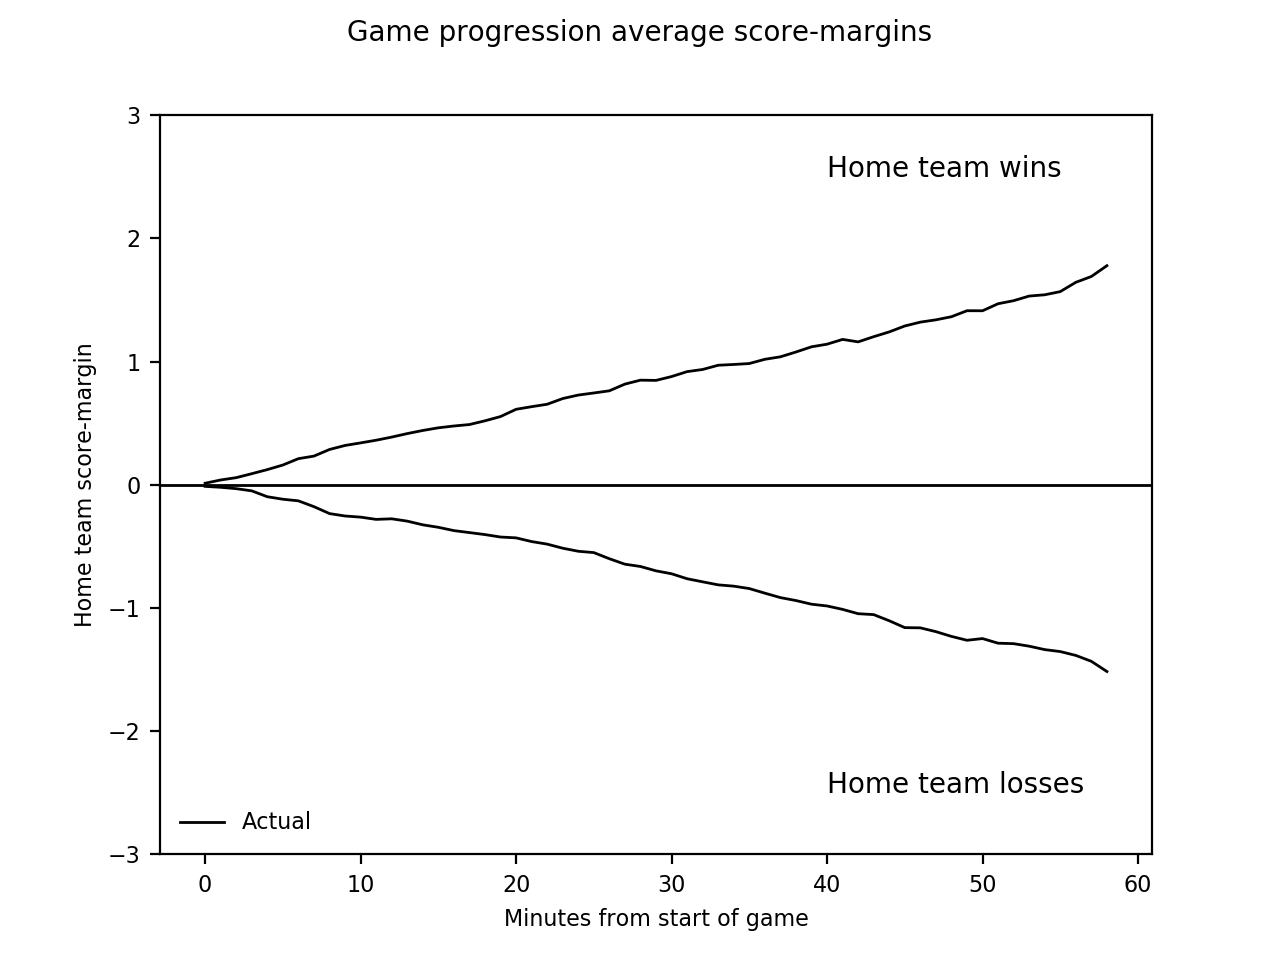

[]

In [48]:
# create index to plot
ds = DS.copy()
ds = ds.reset_index()
ds = ds.rename(columns={'index' : 'minStart'})
ds = ds[ds['minStart']!=0]

# line plot
tempName = 'condLeagueScoreMarginsActu.pdf'
tempFile = os.path.join(tempName)

fig, ax0 = plt.subplots(facecolor='white')
ax0.plot(ds.index, ds['trDScLaActu'], label='Actual'  , marker='', linestyle='-', linewidth=1, color='black')
ax0.plot(ds.index, ds['faDScLaActu'], label='', marker='', linestyle='-', linewidth=1, color='black')
ax0.set_title('', fontsize=8)
ax0.set_xlabel('Minutes from start of game', fontsize=8)
ax0.tick_params(axis='both', labelsize=8)
ax0.set_ylabel('Home team score-margin', fontsize=8)
ax0.set_ylim([-3, 3])
ax0.axhline(y=0,xmin=0,xmax=60,c="black",linewidth=1.0, linestyle='-', zorder=0)
legend = ax0.legend(loc='lower left', shadow=False, fontsize=8, frameon=False)
ax0.text(40,2.5, 'Home team wins', fontsize=10)
ax0.text(40,-2.5, 'Home team losses', fontsize=10)
fig.suptitle("Game progression average score-margins", fontsize=10)
plt.savefig(tempFile)
# plt.close('all')
plt.plot()

## Estimation procedure
* Estimate inverse conditional probabilities; p(HSM|TR)

In [49]:
# adjust score margin states
dm['homeSM'] = dm.apply(lambda x: 3  if x['homeSM'] > 3 else  x['homeSM'], axis=1)
dm['homeSM'] = dm.apply(lambda x: -3 if x['homeSM'] < -3 else x['homeSM'], axis=1)
dm['homeSM'].describe()

# create win and lose specific data sets
dw = dm[dm['homeWin']==1]
dl = dm[dm['homeWin']==0]

### Multinomial Logitisitc regression

In [50]:
trMNL   = sm.MNLogit(dw['homeSM'], sm.add_constant(dw['minStart'])).fit()
trMNL.summary()

Optimization terminated successfully.
         Current function value: 1.469714
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 homeSM   No. Observations:                37754
Model:                        MNLogit   Df Residuals:                    37742
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Mar 2018   Pseudo R-squ.:                 0.05742
Time:                        16:17:45   Log-Likelihood:                -55488.
converged:                       True   LL-Null:                       -58868.
                                        LLR p-value:                     0.000
==============================================================================
 homeSM=-2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1700      0.238      9.101      0.000       1.703       2.637
minStart      -0.0034      0.007     -0.460      0.646      -0.018       0.011
------------------------------------------------------------------------------
 homeSM=-1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8321      0.228     16.825      0.000       3.386       4.278
minStart      -0.0014      0.007     -0.203      0.839      -0.015       0.012
------------------------------------------------------------------------------
  homeSM=0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7159      0.226     25.312      0.000       5.273       6.158
minStart      -0.0237      0.007     -3.430      0.001      -0.037      -0.010
------------------------------------------------------------------------------
  homeSM=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5081      0.226     19.921      0.000       4.065       4.952
minStart       0.0120      0.007      1.729      0.084      -0.002       0.026
------------------------------------------------------------------------------
  homeSM=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2645      0.228     14.329      0.000       2.818       3.711
minStart       0.0314      0.007      4.515      0.000       0.018       0.045
------------------------------------------------------------------------------
  homeSM=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7653      0.231      7.631      0.000       1.312       2.219
minStart       0.0622      0.007      8.894      0.000       0.049       0.076
==============================================================================
"""

In [51]:
faMNL   = sm.MNLogit(dl['homeSM'], sm.add_constant(dl['minStart'])).fit()
faMNL.summary()

Optimization terminated successfully.
         Current function value: 1.432184
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 homeSM   No. Observations:                32095
Model:                        MNLogit   Df Residuals:                    32083
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Mar 2018   Pseudo R-squ.:                 0.05535
Time:                        16:17:45   Log-Likelihood:                -45966.
converged:                       True   LL-Null:                       -48659.
                                        LLR p-value:                     0.000
==============================================================================
 homeSM=-2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7614      0.079     22.292      0.000       1.607       1.916
minStart      -0.0314      0.002    -17.600      0.000      -0.035      -0.028
------------------------------------------------------------------------------
 homeSM=-1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1709      0.073     43.550      0.000       3.028       3.314
minStart      -0.0513      0.002    -31.147      0.000      -0.054      -0.048
------------------------------------------------------------------------------
  homeSM=0       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4692      0.072     62.268      0.000       4.329       4.610
minStart      -0.0870      0.002    -52.279      0.000      -0.090      -0.084
------------------------------------------------------------------------------
  homeSM=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7866      0.077     36.006      0.000       2.635       2.938
minStart      -0.0730      0.002    -38.733      0.000      -0.077      -0.069
------------------------------------------------------------------------------
  homeSM=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8390      0.111      7.544      0.000       0.621       1.057
minStart      -0.0684      0.003    -22.126      0.000      -0.074      -0.062
------------------------------------------------------------------------------
  homeSM=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3667      0.261     -5.234      0.000      -1.878      -0.855
minStart      -0.0634      0.008     -8.283      0.000      -0.078      -0.048
==============================================================================
"""

### Predict probabilities of score states

In [52]:
de1 = pandas.DataFrame(trMNL.predict(sm.add_constant(dm['minStart'])))
de0 = pandas.DataFrame(faMNL.predict(sm.add_constant(dm['minStart'])))
# de0.head(10)

In [53]:
de = de1/de0
de.head()

,0,1,2,3,4,5,6
0,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401
1,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717
2,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132
3,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202
4,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573


In [54]:
# change column names to be consistent with score states
de.columns = de.columns - 3
de.head()

,-3,-2,-1,0,1,2,3
0,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401
1,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717
2,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132
3,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202
4,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573


Merge inverse conditional data frames

In [55]:
dn = pandas.merge(dm, de, left_index=True,right_index=True)
dn.head(20)

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3
0,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401
1,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717
2,20001,3,10/8/2014,2014,1,181,24,TOR,1,0,0,MTL,TOR,MTL,0,0,181,0,0,0,0,-1,NaN,NaN,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132
3,20001,4,10/8/2014,2014,1,256,36,TOR,1,0,0,MTL,TOR,MTL,0,0,256,0,0,0,0,-1,NaN,NaN,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202
4,20001,5,10/8/2014,2014,1,352,42,MTL,0,1,0,MTL,TOR,MTL,0,0,352,0,1,-1,0,-1,NaN,NaN,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573
5,20001,6,10/8/2014,2014,1,376,45,TOR,1,0,1,MTL,TOR,MTL,0,0,376,0,1,-1,0,-1,NaN,NaN,0.191338,0.340737,0.499891,0.972990,1.781953,3.937757,9.319983
6,20001,7,10/8/2014,2014,1,430,47,MTL,0,1,0,MTL,TOR,MTL,0,0,430,0,1,-1,0,-1,NaN,NaN,0.179164,0.328139,0.492011,0.970601,1.816565,4.074199,9.895275
7,20001,8,10/8/2014,2014,1,481,50,MTL,0,1,0,MTL,TOR,MTL,0,0,481,0,1,-1,0,-1,NaN,NaN,0.167753,0.315986,0.484224,0.968155,1.851729,4.215094,10.505397
8,20001,9,10/8/2014,2014,1,540,60,TOR,1,1,1,MTL,TOR,MTL,0,0,540,1,1,0,0,-1,NaN,NaN,0.157059,0.304263,0.476529,0.965652,1.887451,4.360578,11.152409
9,20001,10,10/8/2014,2014,1,600,70,TOR,1,1,1,MTL,TOR,MTL,0,0,600,1,1,0,0,-1,NaN,NaN,0.147036,0.292956,0.468926,0.963093,1.923736,4.510786,11.838492


In [56]:
## obtained game-minute specific inverse conditional
dm = dn.copy()
# create indicator variables
dm['d3'] = dm.apply(lambda x: 1 if x['homeSM']==-3 else 0, axis=1)
dm['d2'] = dm.apply(lambda x: 1 if x['homeSM']==-2 else 0, axis=1)
dm['d1'] = dm.apply(lambda x: 1 if x['homeSM']==-1 else 0, axis=1)
dm['ti'] = dm.apply(lambda x: 1 if x['homeSM']==0  else 0, axis=1)
dm['u1'] = dm.apply(lambda x: 1 if x['homeSM']==1  else 0, axis=1)
dm['u2'] = dm.apply(lambda x: 1 if x['homeSM']==2  else 0, axis=1)
dm['u3'] = dm.apply(lambda x: 1 if x['homeSM']==3  else 0, axis=1)
dm.head(20)

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3,d3,d2,d1,ti,u1,u2,u3
0,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401,0,0,0,1,0,0,0
1,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717,0,0,0,1,0,0,0
2,20001,3,10/8/2014,2014,1,181,24,TOR,1,0,0,MTL,TOR,MTL,0,0,181,0,0,0,0,-1,NaN,NaN,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132,0,0,0,1,0,0,0
3,20001,4,10/8/2014,2014,1,256,36,TOR,1,0,0,MTL,TOR,MTL,0,0,256,0,0,0,0,-1,NaN,NaN,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202,0,0,0,1,0,0,0
4,20001,5,10/8/2014,2014,1,352,42,MTL,0,1,0,MTL,TOR,MTL,0,0,352,0,1,-1,0,-1,NaN,NaN,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573,0,0,1,0,0,0,0
5,20001,6,10/8/2014,2014,1,376,45,TOR,1,0,1,MTL,TOR,MTL,0,0,376,0,1,-1,0,-1,NaN,NaN,0.191338,0.340737,0.499891,0.972990,1.781953,3.937757,9.319983,0,0,1,0,0,0,0
6,20001,7,10/8/2014,2014,1,430,47,MTL,0,1,0,MTL,TOR,MTL,0,0,430,0,1,-1,0,-1,NaN,NaN,0.179164,0.328139,0.492011,0.970601,1.816565,4.074199,9.895275,0,0,1,0,0,0,0
7,20001,8,10/8/2014,2014,1,481,50,MTL,0,1,0,MTL,TOR,MTL,0,0,481,0,1,-1,0,-1,NaN,NaN,0.167753,0.315986,0.484224,0.968155,1.851729,4.215094,10.505397,0,0,1,0,0,0,0
8,20001,9,10/8/2014,2014,1,540,60,TOR,1,1,1,MTL,TOR,MTL,0,0,540,1,1,0,0,-1,NaN,NaN,0.157059,0.304263,0.476529,0.965652,1.887451,4.360578,11.152409,0,0,0,1,0,0,0
9,20001,10,10/8/2014,2014,1,600,70,TOR,1,1,1,MTL,TOR,MTL,0,0,600,1,1,0,0,-1,NaN,NaN,0.147036,0.292956,0.468926,0.963093,1.923736,4.510786,11.838492,0,0,0,1,0,0,0


In [57]:
# multiple inverse conditionals and indicators
dm['invCond']      = dm['d3']*dm[-3] + dm['d2']*dm[-2] + dm['d1']*dm[-1] + dm['ti']*dm[0] + dm['u1']*dm[1] + dm['u2']*dm[2] + dm['u3']*dm[3]
dm.head()

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3,d3,d2,d1,ti,u1,u2,u3,invCond
0,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401,0,0,0,1,0,0,0,0.984085
1,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717,0,0,0,1,0,0,0,0.981979
2,20001,3,10/8/2014,2014,1,181,24,TOR,1,0,0,MTL,TOR,MTL,0,0,181,0,0,0,0,-1,NaN,NaN,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132,0,0,0,1,0,0,0,0.979816
3,20001,4,10/8/2014,2014,1,256,36,TOR,1,0,0,MTL,TOR,MTL,0,0,256,0,0,0,0,-1,NaN,NaN,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202,0,0,0,1,0,0,0,0.977598
4,20001,5,10/8/2014,2014,1,352,42,MTL,0,1,0,MTL,TOR,MTL,0,0,352,0,1,-1,0,-1,NaN,NaN,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573,0,0,1,0,0,0,0,0.507865


In [58]:
# set prior odds and probabilities
dm['priorProb']     = (dm['homeWinPer'] / (dm['homeWinPer'] + dm['awayWinPer'])).fillna(0.5)
dm['priorOdds']     = (dm['homeWinPer'] / dm['awayWinPer']).fillna(1.0)
dm.head(2)

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3,d3,d2,d1,ti,u1,u2,u3,invCond,priorProb,priorOdds
0,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401,0,0,0,1,0,0,0,0.984085,0.5,1.0
1,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717,0,0,0,1,0,0,0,0.981979,0.5,1.0


Calculate posterior odds and probabilities (Bayes Rule)

In [59]:
dm['postOdds']      =  dm['priorOdds'] * dm['invCond']
dm['postProb']      =  dm['postOdds'] / (1 + dm['postOdds'])
dm.head(10)

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3,d3,d2,d1,ti,u1,u2,u3,invCond,priorProb,priorOdds,postOdds,postProb
0,20001,1,10/8/2014,2014,1,65,7,MTL,0,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401,0,0,0,1,0,0,0,0.984085,0.5,1.0,0.984085,0.495989
1,20001,2,10/8/2014,2014,1,132,18,MTL,0,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717,0,0,0,1,0,0,0,0.981979,0.5,1.0,0.981979,0.495454
2,20001,3,10/8/2014,2014,1,181,24,TOR,1,0,0,MTL,TOR,MTL,0,0,181,0,0,0,0,-1,NaN,NaN,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132,0,0,0,1,0,0,0,0.979816,0.5,1.0,0.979816,0.494903
3,20001,4,10/8/2014,2014,1,256,36,TOR,1,0,0,MTL,TOR,MTL,0,0,256,0,0,0,0,-1,NaN,NaN,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202,0,0,0,1,0,0,0,0.977598,0.5,1.0,0.977598,0.494336
4,20001,5,10/8/2014,2014,1,352,42,MTL,0,1,0,MTL,TOR,MTL,0,0,352,0,1,-1,0,-1,NaN,NaN,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573,0,0,1,0,0,0,0,0.507865,0.5,1.0,0.507865,0.336810
5,20001,6,10/8/2014,2014,1,376,45,TOR,1,0,1,MTL,TOR,MTL,0,0,376,0,1,-1,0,-1,NaN,NaN,0.191338,0.340737,0.499891,0.972990,1.781953,3.937757,9.319983,0,0,1,0,0,0,0,0.499891,0.5,1.0,0.499891,0.333285
6,20001,7,10/8/2014,2014,1,430,47,MTL,0,1,0,MTL,TOR,MTL,0,0,430,0,1,-1,0,-1,NaN,NaN,0.179164,0.328139,0.492011,0.970601,1.816565,4.074199,9.895275,0,0,1,0,0,0,0,0.492011,0.5,1.0,0.492011,0.329764
7,20001,8,10/8/2014,2014,1,481,50,MTL,0,1,0,MTL,TOR,MTL,0,0,481,0,1,-1,0,-1,NaN,NaN,0.167753,0.315986,0.484224,0.968155,1.851729,4.215094,10.505397,0,0,1,0,0,0,0,0.484224,0.5,1.0,0.484224,0.326247
8,20001,9,10/8/2014,2014,1,540,60,TOR,1,1,1,MTL,TOR,MTL,0,0,540,1,1,0,0,-1,NaN,NaN,0.157059,0.304263,0.476529,0.965652,1.887451,4.360578,11.152409,0,0,0,1,0,0,0,0.965652,0.5,1.0,0.965652,0.491263
9,20001,10,10/8/2014,2014,1,600,70,TOR,1,1,1,MTL,TOR,MTL,0,0,600,1,1,0,0,-1,NaN,NaN,0.147036,0.292956,0.468926,0.963093,1.923736,4.510786,11.838492,0,0,0,1,0,0,0,0.963093,0.5,1.0,0.963093,0.490600


Game-specific plot of in-game win probabilities

In [60]:
# set gamenumber
d1 = dm[dm['gamenumber']==20801]
print(len(d1))
d1[['gamenumber', 'minStart', 'homeSM', 'priorProb', 'postProb' ]].head()

59


,gamenumber,minStart,homeSM,priorProb,postProb
46492,20801,1,-1,0.605714,0.453747
46493,20801,2,-1,0.605714,0.449890
46494,20801,3,-1,0.605714,0.446024
46495,20801,4,-1,0.605714,0.442148
46496,20801,5,-1,0.605714,0.438265


In [61]:
print ("date, away team, home team")
print (d1.iloc[0]['gamedate'])
print (d1.iloc[0]['vteamcode'])
print (d1.iloc[0]['hteamcode'])
d1.head()

date, away team, home team
2/10/2015
PHI
MTL


,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,teamcode,isthome,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3,d3,d2,d1,ti,u1,u2,u3,invCond,priorProb,priorOdds,postOdds,postProb
46492,20801,1,2/10/2015,2014,1,62,10,MTL,1,0,1,PHI,MTL,MTL,1,0,62,0,1,-1,1,0,0.666667,0.433962,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401,0,0,1,0,0,0,0,0.540709,0.605714,1.536232,0.830654,0.453747
46493,20801,2,2/10/2015,2014,1,125,17,MTL,1,0,1,PHI,MTL,MTL,1,0,125,0,1,-1,1,0,0.666667,0.433962,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717,0,0,1,0,0,0,0,0.532354,0.605714,1.536232,0.817819,0.449890
46494,20801,3,2/10/2015,2014,1,184,23,PHI,0,1,0,PHI,MTL,MTL,1,0,184,0,1,-1,1,0,0.666667,0.433962,0.232966,0.381363,0.524095,0.979816,1.681377,3.553877,7.784132,0,0,1,0,0,0,0,0.524095,0.605714,1.536232,0.805131,0.446024
46495,20801,4,2/10/2015,2014,1,240,29,PHI,0,1,0,PHI,MTL,MTL,1,0,240,0,1,-1,1,0,0.666667,0.433962,0.218184,0.367333,0.515932,0.977598,1.714364,3.677721,8.266202,0,0,1,0,0,0,0,0.515932,0.605714,1.536232,0.792592,0.442148
46496,20801,5,2/10/2015,2014,1,312,35,PHI,0,1,0,PHI,MTL,MTL,1,0,312,0,1,-1,1,0,0.666667,0.433962,0.204327,0.353797,0.507865,0.975322,1.747887,3.805640,8.777573,0,0,1,0,0,0,0,0.507865,0.605714,1.536232,0.780198,0.438265


<IPython.core.display.Javascript object>


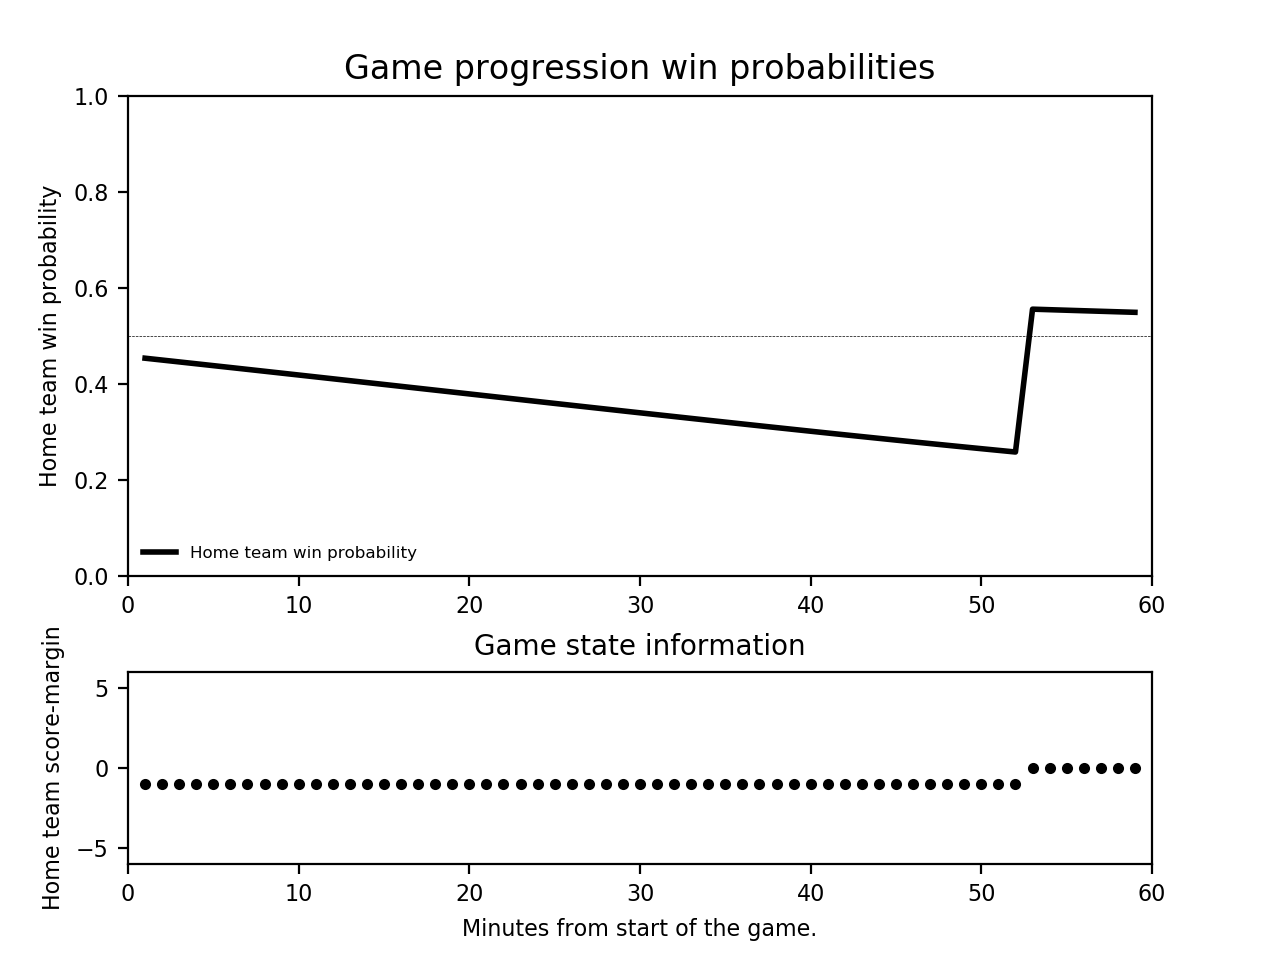

In [62]:
# plot 
plt.rc('axes', grid=False)

width = 0.001
space = width + 0.10
left, width = 0.1, 0.8
rect1 = [left, 0.4, width, 0.5]
rect2 = [left, 0.1, width, 0.2]

fig = plt.figure(facecolor='white')
ax1 = fig.add_axes(rect1, facecolor='white')
ax2 = fig.add_axes(rect2, facecolor='white', sharex=ax1)

ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax1.set_ylim([0,1])
ax2.set_ylim([-6,6])
ax1.set_xlim([0,60])

# ig.suptitle(gameTitle, fontsize=12)
ax1.set_title("Game progression win probabilities", fontsize=12)
ax1.set_ylabel('Home team win probability', fontsize=8)
ax2.set_title('Game state information', fontsize=10, multialignment='center')
ax2.set_ylabel('Home team score-margin', fontsize=8, multialignment='center')
ax2.set_xlabel('Minutes from start of the game.', fontsize=8)

# plot lines
ax1.plot(d1['minStart'], d1['postProb']  , marker='', linestyle='-' , linewidth=2, color='black',  label='Home team win probability')
ax1.axhline(y=.5 ,c="black",linewidth=0.25, linestyle='--', zorder=0)
ax2.plot(d1.minStart, d1.homeSM, '.', linewidth=0.5, color='black')

legend = ax1.legend(loc='lower left', shadow=False, fontsize=6, frameon=False)

# save figure
plt.savefig("gn500.pdf", format='pdf')
# plt.close('all')
plt.show()

## complete

### Done